# Visualisation

This notebook contain the codes for creating figures for the CCN 2025 paper.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import xarray as xr
from pathlib import Path

from scipy.signal import sosfiltfilt, butter, sosfilt
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch

import torch
import keras

from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm
import mne

def _smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Feature extraction
def time_domain_features_multi_channel(x, axis=-1):  # x: (n_samples, n_channels, n_timepoints)
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)
    kurtosis_ = kurtosis(x, axis=axis)
    rms = np.sqrt(np.mean(x**2, axis=axis))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=-1)  # (n_samples, n_channels, n_features)

def hjorth_parameters_multi_channel(signal, axis=-1): 
    activity = np.var(signal, axis=axis)
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility
    return np.stack([activity, mobility, complexity], axis=-1)

def spectral_features_multi_channel(signal, fs=128, nperseg=512):
    f, Pxx = welch(signal, fs=fs, nperseg=nperseg, axis=-1)
    total_power = np.sum(Pxx, axis=-1)
    delta = np.sum(Pxx[:, :, (f >= 0.25) & (f < 4)], axis=-1) / total_power
    theta = np.sum(Pxx[:, :, (f >= 4) & (f < 8)], axis=-1) / total_power
    alpha = np.sum(Pxx[:, :, (f >= 8) & (f < 13)], axis=-1) / total_power
    beta = np.sum(Pxx[:, :, (f >= 13) & (f <= 30)], axis=-1) / total_power
    gamma = np.sum(Pxx[:, :, (f > 30) & (f <= 50)], axis=-1) / total_power
    pxx_entropy = entropy(Pxx, axis=-1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=-1)


def aggregate_features(real_signal, gen_signal):
    # Extract features
    real_time_features = time_domain_features_multi_channel(real_signal)
    real_hjorth_features = hjorth_parameters_multi_channel(real_signal)
    real_spectral_features = spectral_features_multi_channel(real_signal)
    
    gen_time_features = time_domain_features_multi_channel(gen_signal)
    gen_hjorth_features = hjorth_parameters_multi_channel(gen_signal)
    gen_spectral_features = spectral_features_multi_channel(gen_signal)
    
    # Concatenate features
    real_features = np.concatenate([real_time_features, real_hjorth_features, real_spectral_features], axis=-1)
    gen_features = np.concatenate([gen_time_features, gen_hjorth_features, gen_spectral_features], axis=-1)
    
    # Reshape to 2D for FID
    real_features = real_features.reshape(real_features.shape[0], -1)  # Flatten across channels
    gen_features = gen_features.reshape(gen_features.shape[0], -1)
    
    return real_features, gen_features

# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid


def plot_psd_multi_channel(x, channels, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd, label=label)
        ax.set_title(f'Channel {channels[c]}')
    else:
        plt.plot(freq, psd, label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def generate_data(model,x, sub, pos, latent_dim=128):
    B, T, C = x.shape
    x_mean = x.mean()
    x_std = x.std()
    l = len(x)
    x_gen = torch.zeros((B, T, C))
    for i in range(int(l/100)):
        x_gen[i*100:(i+1)*100] = model.generator((keras.random.normal((1, latent_dim), mean=x_mean, stddev=x_std),
                                                  sub[i].to('mps'),
                                                  pos[i].to('mps'))).cpu().detach()
    return x_gen

# DATA & Model

In [2]:
# Real DATA
filtering = True
time_dim = 1024
n_subject = 202
exclude_sub_ids = None
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

# data
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject])
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
    sub_ids = xarray.subject[:n_subject].to_numpy()
x = x.to_numpy()

if filtering:
    sos = butter(4, 0.5, btype='high', fs=128, output='sos')
    x = sosfiltfilt(sos, x, axis=-1)
x = torch.tensor(x.copy()).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = torch.tensor(np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis])

pos = torch.tensor(xarray.ch_positions[None].repeat(x.shape[0], 0))
data = {'x': x, 'sub': sub, 'pos': pos}

In [9]:
from src.EEGModalNet.models.WGAN import WGAN_GP
latent_dim = 128
model = WGAN_GP(time_dim=1024, feature_dim=len(channels),
                latent_dim=latent_dim, n_subjects=202,
                use_sublayer_generator=True,
                use_sublayer_critic=False,
                use_channel_merger_g=False,
                use_channel_merger_c=False,
                kerner_initializer='random_normal',
                interpolation='bilinear')

# load model and history
chkpoint_dir = 'logs/27.01.2025_epoch_500.model.keras'
model.load_weights(chkpoint_dir)


# x_generated

/opt/homebrew/Caskroom/miniforge/base/envs/MNE/lib/python3.12/site-packages/keras/src/backend/torch/linalg.py:53: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1738206012956/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.linalg.qr(x, mode=mode)


In [ ]:
x_gen = generate_data(model, x, sub, pos, latent_dim=latent_dim)

In [16]:
stats = pd.read_csv('logs/27.01.2025.csv').dropna(axis=1)

# Training Stats
## Figure 2

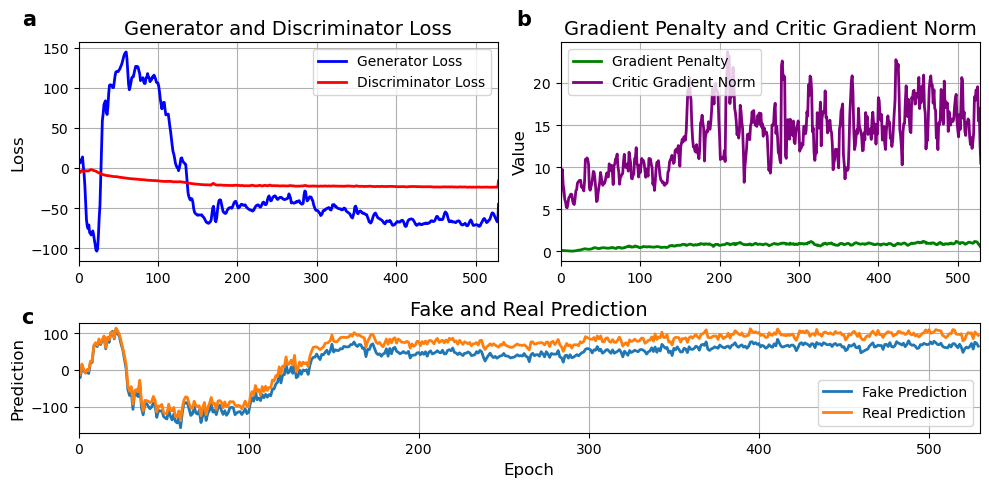

In [49]:
import matplotlib.gridspec as gridspec

lim = len(stats)

# Create a figure
fig = plt.figure(figsize=(10, 5))

# Create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])

# First subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(_smooth(stats['g_loss'], 3), label='Generator Loss', color='blue', linestyle='-', linewidth=2)
ax1.plot(_smooth(stats['d_loss'], 3), label='Discriminator Loss', color='red', linestyle='-', linewidth=2)
ax1.legend()
ax1.grid(True)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xlim([0, lim-2])
ax1.set_title('Generator and Discriminator Loss', fontdict={'fontsize': 14})
ax1.text(-0.1, 1.15, 'a', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# Second subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(_smooth(stats['_gp'], 5), label='Gradient Penalty', color='green', linestyle='-', linewidth=2)
ax2.plot(_smooth(stats['critic_grad_norm'], 5), label='Critic Gradient Norm', color='purple', linestyle='-', linewidth=2)
ax2.legend()
ax2.grid(True)
ax2.set_xlim([0, lim-2])
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Gradient Penalty and Critic Gradient Norm', fontdict={'fontsize': 14})
ax2.text(-0.07, 1.15, 'b', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# Third subplot  # TODO: Add std
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(stats['_fake_pred'], label='Fake Prediction',  linestyle='-', linewidth=2)
ax3.plot(stats['_real_pred'], label='Real Prediction', linestyle='-', linewidth=2)
ax3.legend()
ax3.grid(True)
ax3.set_xlim([0, lim])
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Prediction', fontsize=12)
ax3.set_title('Fake and Real Prediction', fontdict={'fontsize': 14})
ax3.text(-0.05, 1.15, 'c', transform=ax3.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

# Result 1: Compare real and generated data

## Explore time domain

In [6]:
real_data = x.flatten(0, 1).reshape(n_subject, -1, len(channels))
fake_data = x_gen.flatten(0, 1).reshape(n_subject, -1, len(channels))

### downsampling

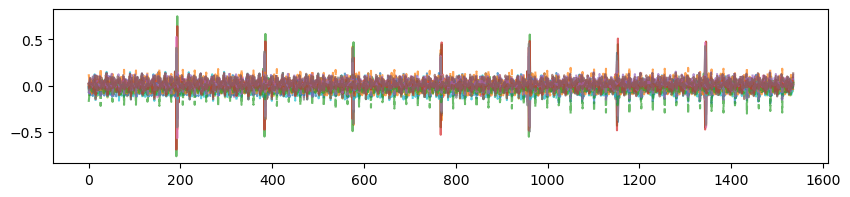

In [91]:
from scipy.signal import resample_poly

downsampled_real = np.array([resample_poly(subj, up=1, down=40) for subj in real_data])
downsampled_fake = np.array([resample_poly(subj, up=1, down=40) for subj in fake_data])

avg_real = np.mean(downsampled_real, axis=0)
avg_fake = np.mean(downsampled_fake, axis=0)

plt.figure(figsize=(10, 2))
plt.plot(avg_real, label="Real (Avg)", alpha=0.7)
plt.plot(avg_fake, label="Generated (Avg)", alpha=0.7, linestyle="dashed")
plt.show()

### plot random data

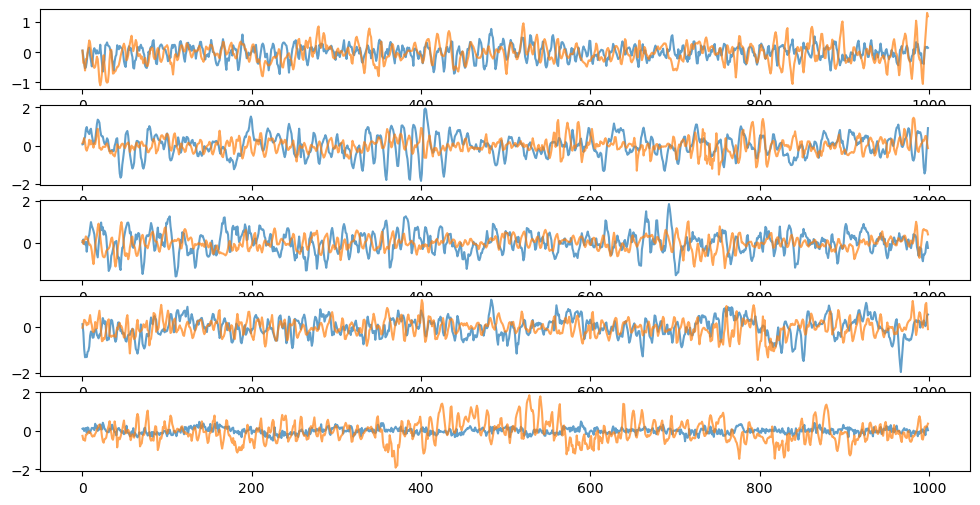

In [39]:
import random

sample_ids = random.sample(range(len(real_data)), 5)  # Pick 5 random participants

ch = 0

plt.figure(figsize=(12, 6))
for i, subj_id in enumerate(sample_ids):
    plt.subplot(5, 1, i + 1)
    plt.plot(real_data[subj_id][:1000, ch], label="Real", alpha=0.7)
    plt.plot(fake_data[subj_id][:1000, ch], label="Generated", alpha=0.7)
    # plt.legend()
plt.show()

### Plot Variability

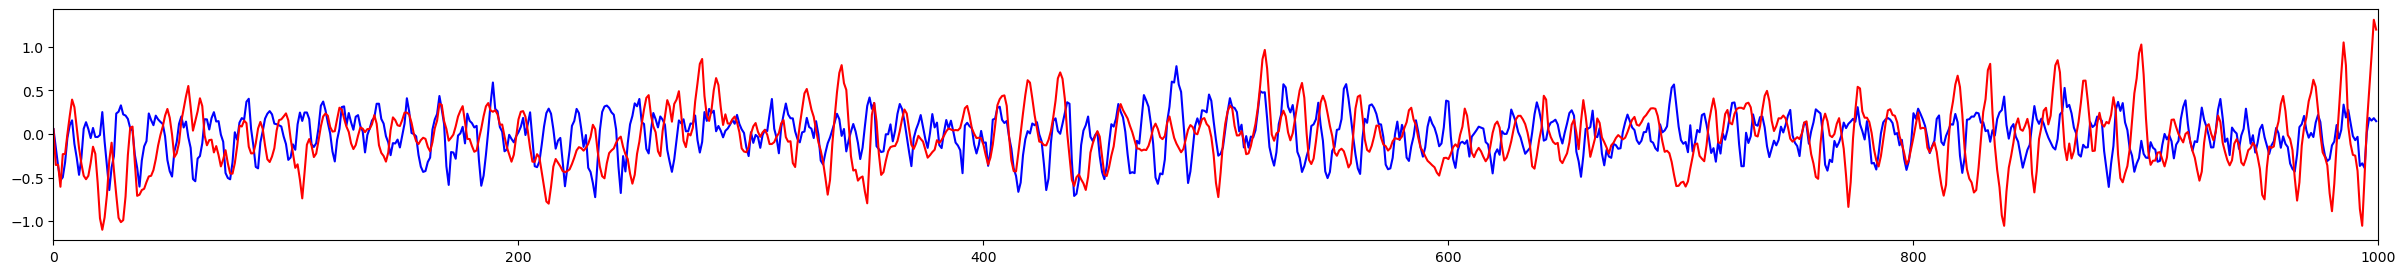

In [56]:
import seaborn as sns

plt.figure(figsize=(30, 3))
sns.lineplot(data=real_data[sample_ids[0], :1000, 0], estimator="mean", errorbar="sd", color="blue")
sns.lineplot(data=fake_data[sample_ids[0], :1000, 0], estimator="mean", errorbar="sd", color="red")
plt.xlim([0, 1000])
plt.show()


### Time-frequency representation

In [104]:
f_real.shape, t_real.shape, Sxx_real.shape

((129,), (8,), (129, 8))

In [102]:
avg_real = real_data.mean(axis=0)[:2000, 0]
avg_fake = fake_data.mean(axis=0)[:2000, 0]

avg_real.shape

torch.Size([2000])

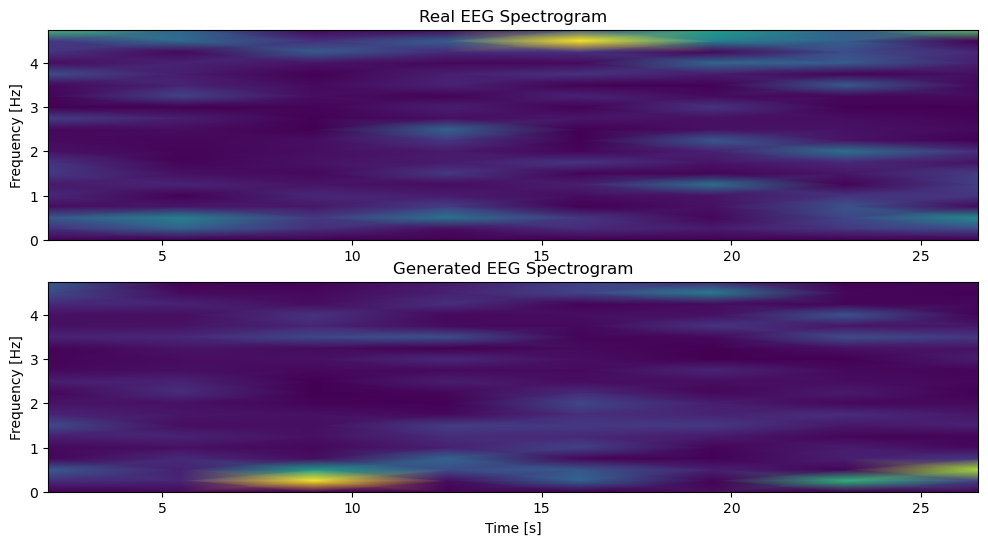

In [114]:
from scipy.signal import spectrogram

f_fake, t_fake, Sxx_fake = spectrogram(avg_fake, fs=64)
f_real, t_real, Sxx_real = spectrogram(avg_real, fs=64)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_real, f_real[:20], Sxx_real[:20], shading='gouraud', vmin=Sxx_real.min(), vmax=Sxx_real.max())
plt.title("Real EEG Spectrogram")
plt.ylabel("Frequency [Hz]")

plt.subplot(2, 1, 2)
plt.pcolormesh(t_fake, f_fake[:20], Sxx_fake[:20], shading='gouraud')
plt.title("Generated EEG Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.show()

### Topomap

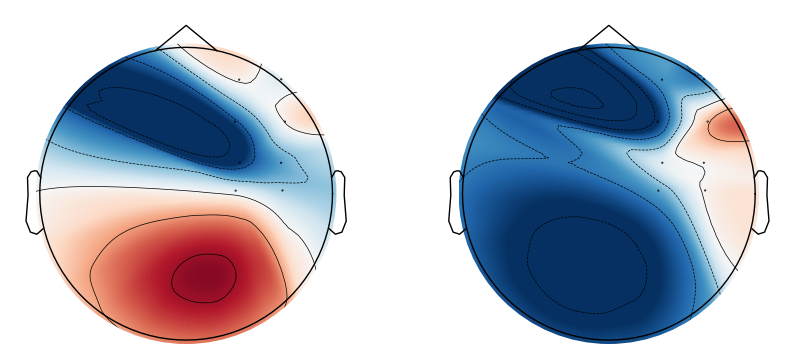

In [12]:
ch_pos = xarray.ch_positions
# compute psd for raw topomap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mne.viz.plot_topomap(real_data[2].T.mean(1), ch_pos, show=False, sphere=1, axes=axes[0])
mne.viz.plot_topomap(fake_data[2].T.mean(1), ch_pos, sphere=1, axes=axes[1])
plt.show()

### Plot averaged data over segment dimension

In [68]:
def plot_psd_multi_channel(x, channels, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd.mean(0), label=label)
        ax.fill_between(freq, psd.mean(0) - psd.std(0), psd.mean(0) + psd.std(0), alpha=0.5)
        ax.set_title(f'Channel {channels[c]}', color='blue', fontsize=10, loc='left')
    else:
        plt.plot(freq, psd.mean(0), label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def plot_time_domain(x, x_gen, ax, ch=0):
    real_data_avg = x[:, :, ch].mean(axis=0)
    fake_data_avg = x_gen[:, :, ch].mean(axis=0)
    ax.plot(real_data_avg, label="Real")
    ax.plot(fake_data_avg, label="Generated", color='red')
    ax.fill_between(np.arange(time_dim), real_data_avg - x[:, :, 0].std(axis=0), real_data_avg + x[:, :, 0].std(axis=0), alpha=0.5)
    ax.fill_between(np.arange(time_dim), fake_data_avg - x_gen[:, :, 0].std(axis=0), fake_data_avg + x_gen[:, :, 0].std(axis=0), alpha=0.5)
    ax.set_title(f'Channel {channels[ch]}', fontsize=10, color='blue', loc='left')
    plt.xlim([0, time_dim])
    plt.ylim([-0.5, 0.5])

## Figure 3

In [105]:
def plot_psd_multi_channel(x, channels, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd.mean(0), label=label)
        ax.fill_between(freq, psd.mean(0) - psd.std(0), psd.mean(0) + psd.std(0), alpha=0.5)
        ax.set_title(f'Channel {channels[c]}', color='blue', fontsize=14, loc='left')
        ax.set_xlim([0.7, 60])
    else:
        plt.plot(freq, psd.mean(0), label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def plot_time_domain(x, x_gen, ax, ch=0):
    real_data_avg = x[:, :, ch].mean(axis=0)
    fake_data_avg = x_gen[:, :, ch].mean(axis=0)
    ax.plot(fake_data_avg, label="Generated")
    ax.plot(real_data_avg, label="Real")
    ax.fill_between(np.arange(time_dim),
                fake_data_avg - x_gen[:, :, 0].std(axis=0),
                fake_data_avg + x_gen[:, :, 0].std(axis=0),
                alpha=0.5)

    ax.fill_between(np.arange(time_dim),
                    real_data_avg - x[:, :, 0].std(axis=0),
                    real_data_avg + x[:, :, 0].std(axis=0),
                    alpha=0.5)

    ax.set_title(f'Channel {channels[ch]}', fontsize=14, color='blue', loc='left')
    ax.set_xlim([0, time_dim])
    ax.set_ylim([-0.5, 0.5])

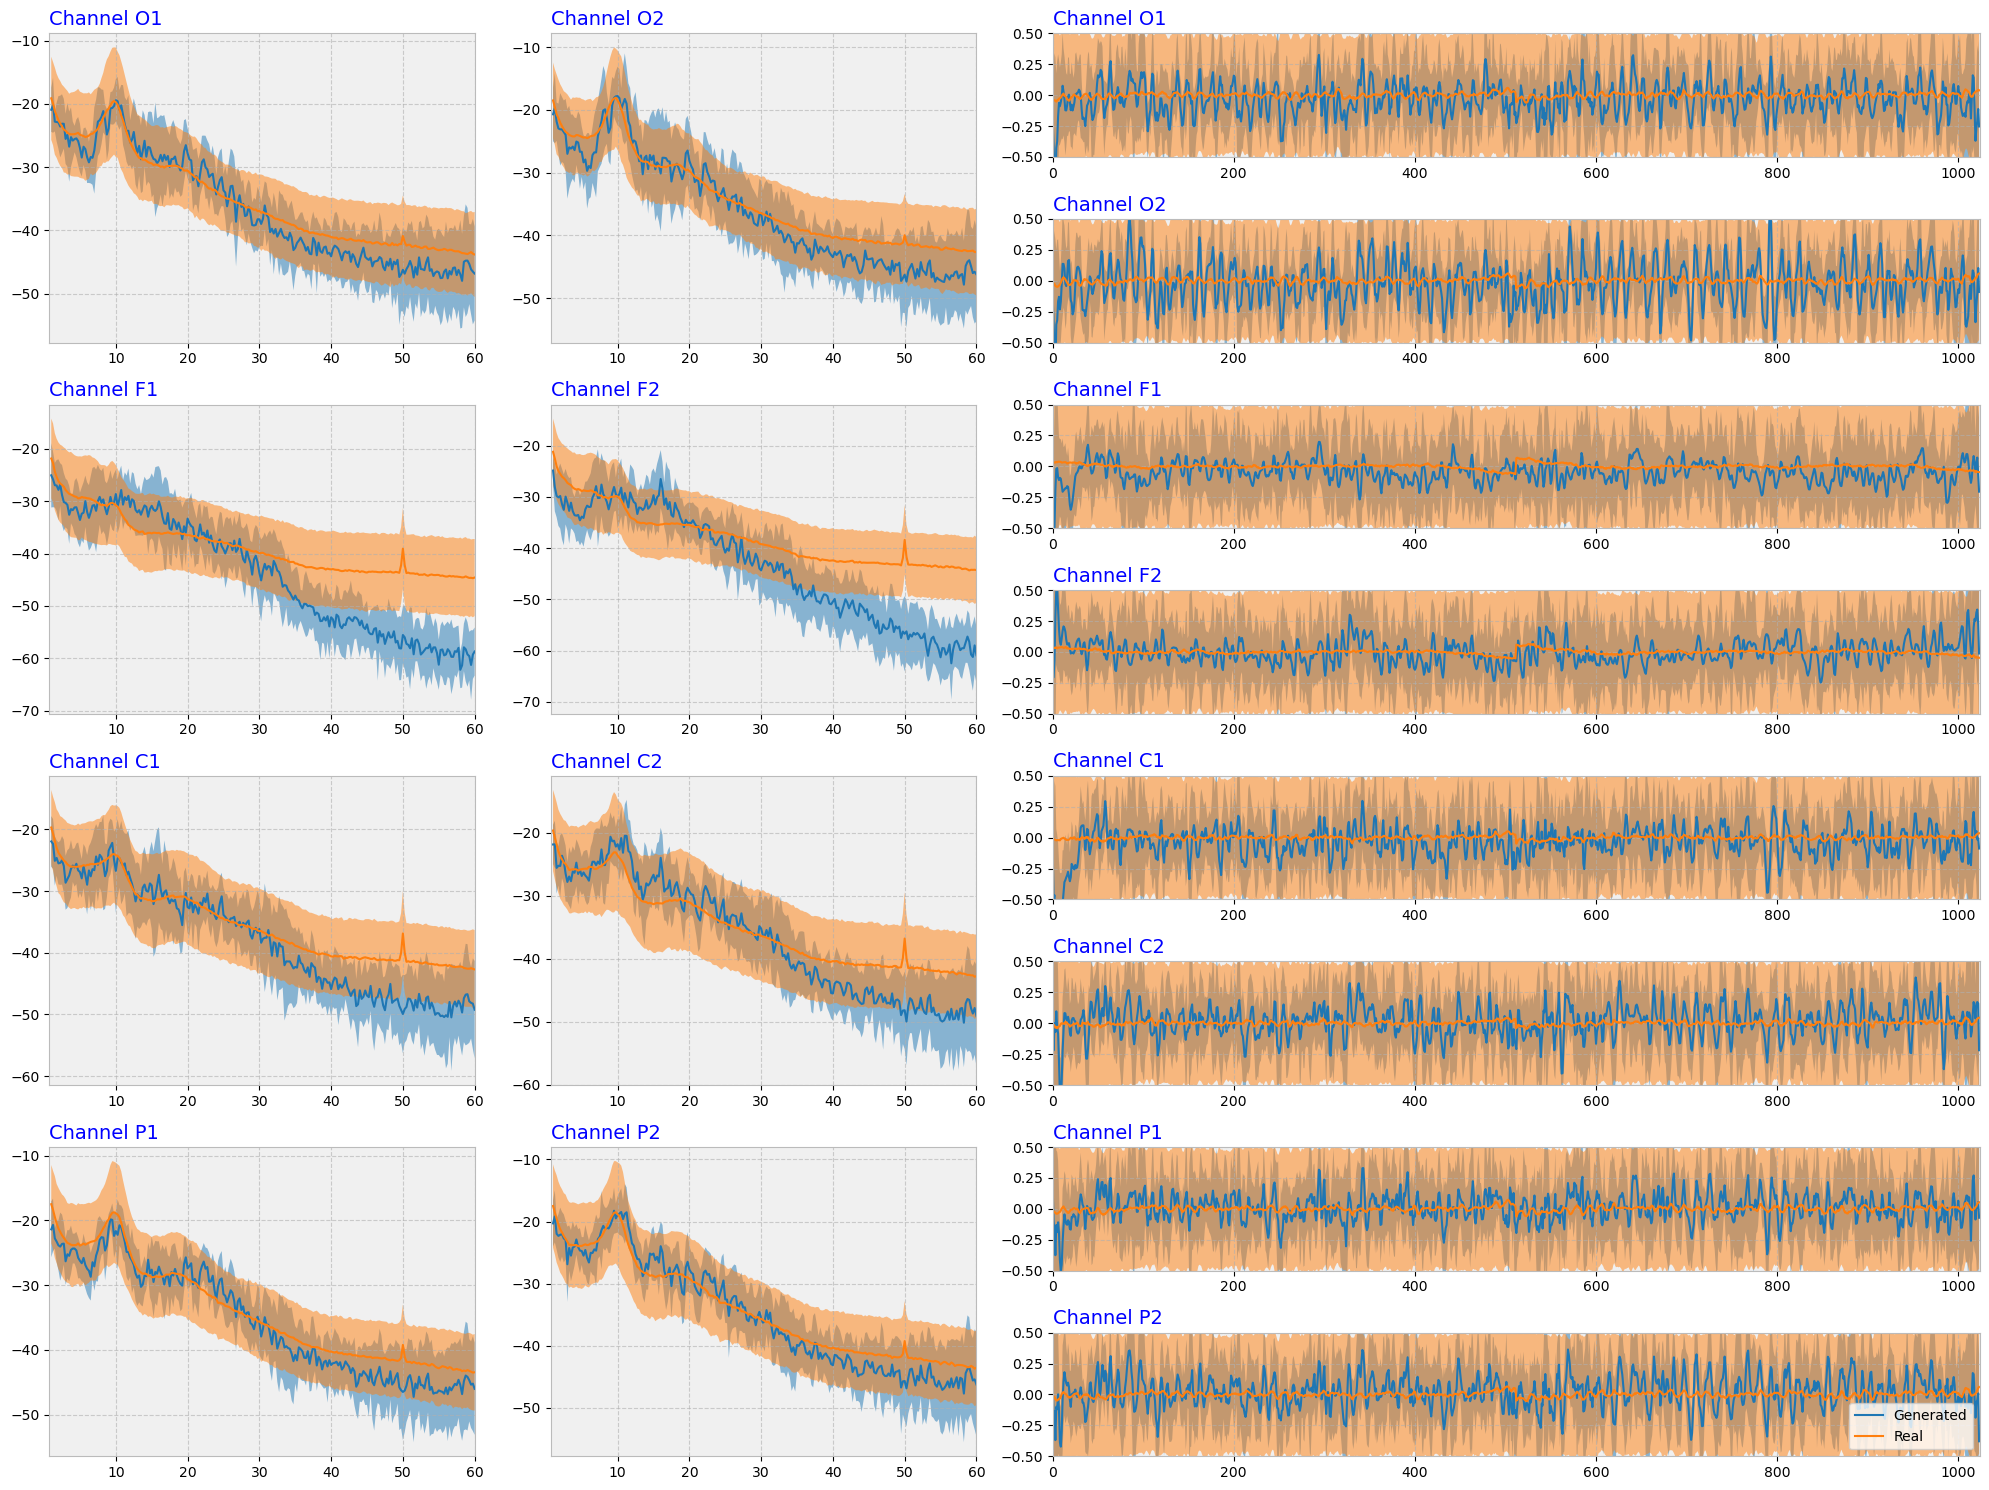

In [106]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(8, 4, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1], width_ratios=[1, 1, 1, 1])

axes = []
for i in range(0, 8, 2):
    axes.append(fig.add_subplot(gs[i:i+2, 0]))
    axes.append(fig.add_subplot(gs[i:i+2, 1]))
    axes.append(fig.add_subplot(gs[i, 2:]))
    axes.append(fig.add_subplot(gs[i+1, 2:]))

for n, i in enumerate(range(0, 8, 2)):
    plot_psd_multi_channel(x_gen, channels=channels, c=i, label='generated', show=False, db=True, ax=axes[n*4])
    plot_psd_multi_channel(x, channels=channels, c=i, label='real', show=False, db=True, ax=axes[n*4])

    plot_psd_multi_channel(x_gen, channels=channels, c=i+1, label='generated', show=False, db=True, ax=axes[(n*4)+1])
    plot_psd_multi_channel(x, channels=channels, c=i+1, label='real', show=False, db=True, ax=axes[(n*4)+1])

    plot_time_domain(x, x_gen, ax=axes[(n*4)+2], ch=i)
    plot_time_domain(x, x_gen, ax=axes[(n*4)+3], ch=i+1)

# Add styling
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('#f0f0f0')
    for spine in ax.spines.values():
        spine.set_edgecolor('#bbbbbb')

plt.legend()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)
plt.tight_layout()
plt.show()


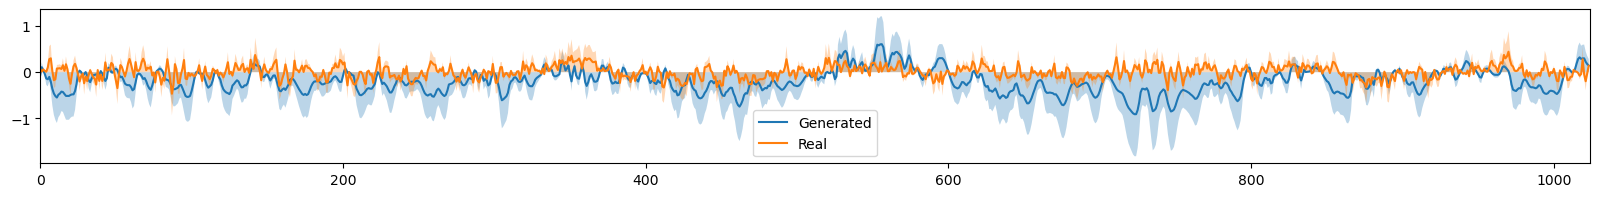

In [82]:
plt.figure(figsize=(20, 2))
plt.plot(x_gen[:, :, 0].mean(axis=0))
plt.plot(data['x'][:, :, 0].mean(axis=0))
plt.xlim([0, time_dim])

## Figure 4

FID and dimentionally reduced graphs

In [35]:
# FID calculation for different models and plot them across the epochs
all_fids = {}

for path in Path('logs').glob('27*.model.keras'):
    model_name = path.stem.split('.')[2][5:]
    model.load_weights(path)
    print(f'Calculating FID for {model_name}...')
    # generated data
    x_gen = generate_data(x, model)

    for j, func in enumerate([hjorth_parameters_multi_channel,
                              spectral_features_multi_channel,
                              time_domain_features_multi_channel]):

        real_f = func(x.permute(0, 2, 1).cpu().detach().numpy())
        real_f = real_f.reshape(real_f.shape[0], -1)  # Flatten across channels
        gen_f = func(x_gen.permute(0, 2, 1).cpu().detach().numpy())
        gen_f = gen_f.reshape(gen_f.shape[0], -1)
        # TODO: consider standardizing the features before computing FID
        all_fids[f'{model_name}-{func.__name__[:-14]}'] = compute_fid(real_f, gen_f)

all_fids_df = pd.DataFrame(all_fids, index=[0])
all_fids_df = pd.DataFrame(all_fids, index=[0])
all_fids_df = all_fids_df.melt(var_name='name', value_name='FID')
all_fids_df[['model', 'feature']] = all_fids_df['name'].apply(lambda x: x.split('-')).apply(pd.Series)
all_fids_df.drop('name', axis=1, inplace=True)

# dimensionality reduction techniques
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
real_fake = np.concatenate([x.flatten(0, 1), x_gen.flatten(0, 1)], axis=0)
real_fake_dec = pca.fit_transform(real_fake)

# last epoch data
epoch_500_data = all_fids_df.set_index('model').loc['epoch_500'].reset_index(drop=True)[['feature', 'FID']]

Calculating FID for best_gloss...
Calculating FID for best_dloss...
Calculating FID for epoch_500...


In [ ]:
# TODO: Use GPU with RAPIDS cuML (Super Fast!)
from cuml.manifold import UMAP
reducer = UMAP(n_components=2)
real_fake = np.concatenate([x.flatten(0, 1), x_gen.flatten(0, 1)], axis=0)
umap_data = reducer.fit_transform(real_fake)

/opt/homebrew/Caskroom/miniforge/base/envs/MNE/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_68399/1281325048.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/MNE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


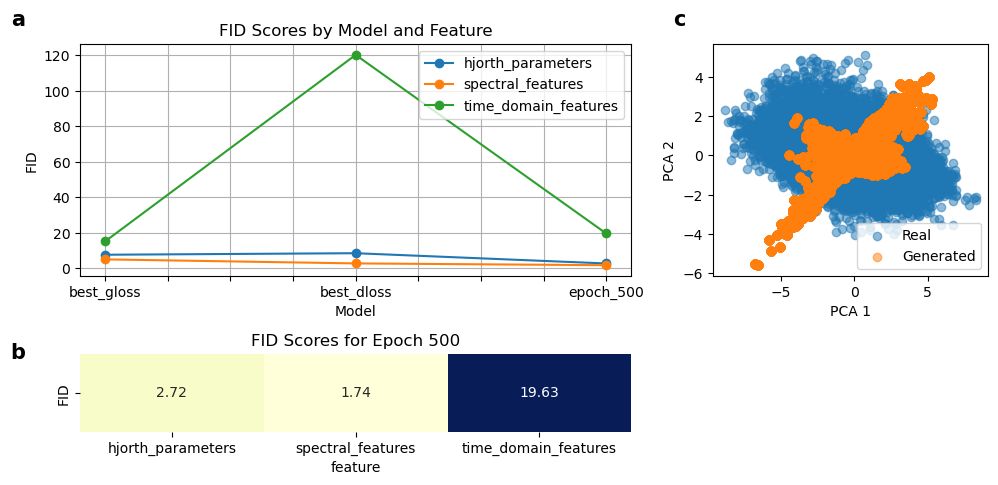

In [ ]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[3, 1], width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
for key, grp in all_fids_df.groupby('feature'):
    grp.plot(ax=ax1, kind='line', x='model', y='FID', marker='o', label=key)
ax1.set_xlabel('Model')
ax1.set_ylabel('FID')
ax1.set_title('FID Scores by Model and Feature')
ax1.grid(True)
ax1.text(-0.1, 1.15, 'a', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(real_fake_dec[:len(x)*time_dim, 0], real_fake_dec[:len(x)*time_dim, 1], label='Real', alpha=0.5)
ax2.scatter(real_fake_dec[len(x)*time_dim:, 0], real_fake_dec[len(x)*time_dim:, 1], label='Generated', alpha=0.5)
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.legend()
ax2.text(-0.1, 1.15, 'c', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[1, 0])
# TODO consider using prettytable, tabulate, or pandas for better table formatting
sns.heatmap(epoch_500_data.pivot_table(index='feature', values='FID').T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, ax=ax3)
ax3.set_title('FID Scores for Epoch 500')
ax3.text(-0.1, 1.15, 'b', transform=ax3.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

# Result 2: downstream task (geneder classification)

## Figure 5

In [3]:
X_input = x
labels = xarray.gender - 1
y = labels.repeat(x.shape[0]//202)
sub_ids_classifier = sub.squeeze().numpy()

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.utils import class_weight
# prepare Kfold cross validation
cross_val = False

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(x, y, groups=sub_ids_classifier):
        train_val_splits.append((train_idx, val_idx))

    # make sure that the splits are stratified and ther is a balance between the classes
    for train_idx, val_idx in train_val_splits:
        print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=5)  # random state == 9
    train_idx, val_idx = next(group_shuffle.split(X_input, y, groups=sub_ids_classifier))
    print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

[0.36024845 0.63975155] [0.3902439 0.6097561]


In [68]:
critic = model.critic.model

# 2. Remove or ignore the last layer (the Dense(1) for the critic’s real/fake task)
#    and connect a new layer of your choice
critic_output = critic.get_layer('dis_flatten').output  # the 4096-dim layer

# 3. new binary classifier
#    e.g., reduce dimension + final sigmoid
# x = keras.layers.Dense(256, activation='relu')(critic_output)
# x = keras.layers.Dropout(0.3)(x)
new_output = keras.layers.Dense(1, activation='sigmoid')(critic_output)

new_model = keras.Model(inputs=critic.layers[0].input, outputs=new_output)

# 4. Freeze the original layers
for layer in new_model.layers[:-8]:
    layer.trainable = False

# 5. Compile and train
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# TODO: add a callback to save the best model based on validation accuracy
# TODO: maybe use eye open data for this task
# TODO: add a callback to reduce the learning rate on plateau
# TODO: evalute model on onseen data (maybe the OTKA dataset)
# TODO: I might need to add a dropout layer to prevent the model from overfitting
# TODO: might want to use other metrics such as AUC instead of accuracy

history = new_model.fit(X_input[train_idx], y[train_idx], 
                        epochs=100, 
                        class_weight=class_weights,
                        batch_size=128,
                        validation_data=(X_input[val_idx], y[val_idx]))

# history_df = pd.DataFrame(history.history)
# history_df.to_csv('logs/31.01.2025_geneder_classifier.csv')

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7881 - loss: 0.4946 - val_accuracy: 0.6520 - val_loss: 0.7528
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7926 - loss: 0.4777 - val_accuracy: 0.6028 - val_loss: 0.7921
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7926 - loss: 0.4761 - val_accuracy: 0.6423 - val_loss: 0.7625
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.7996 - loss: 0.4791 - val_accuracy: 0.6382 - val_loss: 0.7699
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7988 - loss: 0.4637 - val_accuracy: 0.6350 - val_loss: 0.8277
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7924 - loss: 0.4698 - val_accuracy: 0.6207 - val_loss: 0.7756
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8010 - loss: 0.4618 - val_accuracy: 0.6276 - val_loss: 0.7965
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7930 - loss: 0.4753 - val_accuracy: 0.

In [ ]:
# save new history

history0 = pd.read_csv('logs/31.01.2025_geneder_classifier.csv', index_col=0)
history1 = pd.read_csv('logs/31.01.2025_geneder_classifier_round2.csv', index_col=0)
history_all = pd.concat([history0, history1], axis=0).reset_index(drop=True)

# save the model and the history
# TODO: fix the saving of the model
new_model.save('logs/31.01.2025_geneder_classifier_round2.model.keras')

In [72]:
y_shuffled = y.copy()
np.random.shuffle(y_shuffled)

# TODO bootstrap the evaluation
acc_shuff = new_model.evaluate(X_input[val_idx], y_shuffled[val_idx])[1]
acc = new_model.evaluate(X_input[val_idx], y[val_idx])[1]

print(f'Accuracy on the shuffled data: {acc_shuff}')
print(f'Accuracy on the original data: {acc}')

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5304 - loss: 1.1838
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6339 - loss: 0.8519
Accuracy on the shuffled data: 0.5308942794799805
Accuracy on the original data: 0.6182926893234253


<Figure size 1000x500 with 0 Axes>

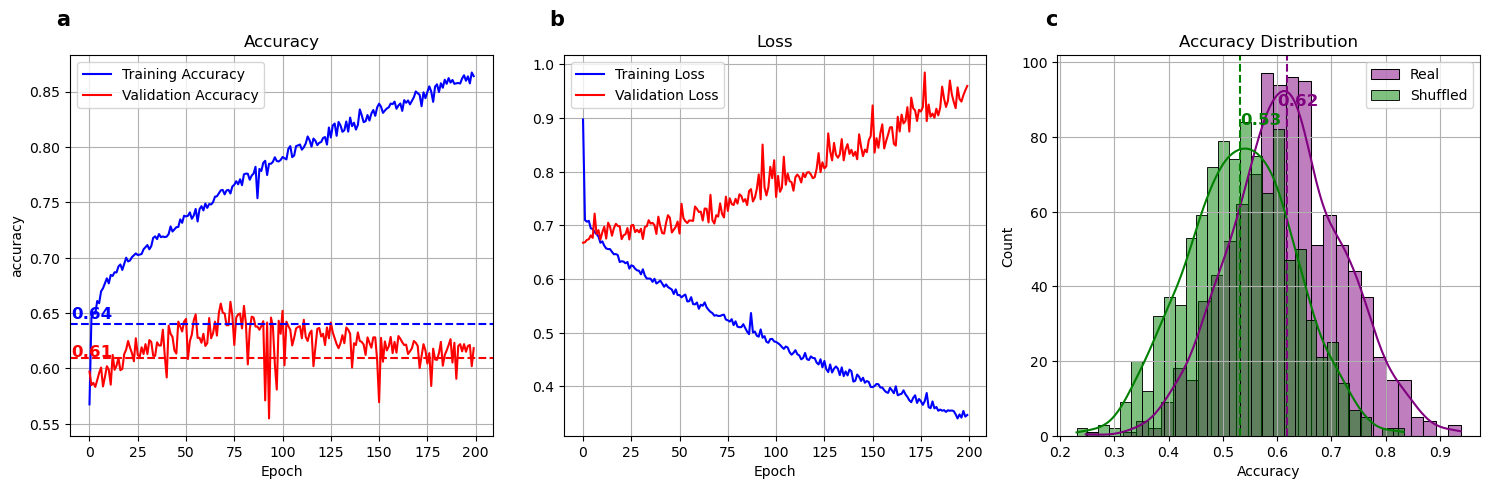

In [96]:
# plot the history of the model
plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(history_all['accuracy'], label='Training Accuracy', color='blue', ax=axes[0])
sns.lineplot(history_all['val_accuracy'], label='Validation Accuracy', color='red', ax=axes[0])
axes[0].legend()
axes[0].axhline(0.6097561, color='red', linestyle='--', label='Baseline Acc (Val)')
axes[0].axhline(0.63975155, color='blue', linestyle='--', label='Baseline Acc (Train)')
axes[0].text(0.1, 0.24, f'{0.6097561:.2f}', color='red', transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right',)
axes[0].text(0.1, 0.34, f'{0.63975155:.2f}', color='blue', transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right',)
axes[0].set_title('Accuracy')
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].text(0, 1.12, 'a', transform=axes[0].transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

axes[1].plot(history_all['loss'], label='Training Loss', color='blue')
axes[1].plot(history_all['val_loss'], label='Validation Loss', color='red')
axes[1].legend()
axes[1].set_title('Loss')
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].text(0, 1.12, 'b', transform=axes[1].transAxes, fontsize=15, fontweight='bold', va='top', ha='right')


sns.histplot(np.random.normal(acc, 0.1, 1000), bins=30, alpha=0.5, label='Real', color='purple', kde=True, fill=True, ax=axes[2])
sns.histplot(np.random.normal(acc_shuff, 0.1, 1000), bins=30, alpha=0.5, label='Shuffled', color='green', kde=True, fill=True, ax=axes[2])
axes[2].axvline(acc, color='purple', linestyle='--')
axes[2].set_title('Accuracy Distribution')
axes[2].set_xlabel('Accuracy')
axes[2].legend()
axes[2].grid(True)
axes[2].text(acc, 0.9, f'{acc:.2f}', transform=axes[2].transAxes, fontsize=12, fontweight='bold', va='top', ha='right', color='purple')
axes[2].text(acc_shuff, 0.85, f'{acc_shuff:.2f}', transform=axes[2].transAxes, fontsize=12, fontweight='bold', va='top', ha='right', color='green')
axes[2].axvline(acc_shuff, color='green', linestyle='--')
axes[2].text(0, 1.12, 'c', transform=axes[2].transAxes, fontsize=15, fontweight='bold', va='top', ha='right')


plt.tight_layout()
plt.show()